In [1]:
import numpy as np
import pandas as pd


from average_atom.core.average_atom import NeutralPseudoAtom as NPA
from average_atom.core.misc import jacobi_relaxation, sor
from average_atom.core.grids import NonUniformGrid
from average_atom.core.physics import ThomasFermi, FermiDirac

from importlib import reload
try:
    reload(physics)
    reload(grids)
    reload(average_atom_geometric)
#     reload(average_atom)
    reload(misc)
except NameError as e:
    from average_atom.core import physics as physics
    from average_atom.core import average_atom as average_atom
    from average_atom.core import misc as misc
    from average_atom.core import grids as grids
    print("Error: ",e)
except Exception as e:
    print("Unexpected error during reload")
    print(e)

import matplotlib.pyplot as plt

from hnc.hnc.constants import *
from hnc.hnc.misc import rs_from_n, n_from_rs

import cProfile

plt.rcParams.update({'font.size': 10})
plt.rcParams["figure.figsize"] = (5,3.5)
plt.rcParams["figure.dpi"] = 200
plt.rcParams['xtick.labelsize']=14

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']



Error:  name 'physics' is not defined


In [17]:
# Aluminuma
name='Al'
Z, A = 13, 27 
Z, A = 13, 27 

ρ_solid = 2.699 #g/cc, the solid density of aluminum 
ρ = 0.01*ρ_solid#8.1 # g/cc
ni_cc = ρ/(A*amu_to_AU*AU_to_g)
ni_AU = ni_cc*invcc_to_AU
rs = rs_from_n(ni_AU)

Ti_eV = 1 
Te_eV = 1

Te_AU = Te_eV*eV_to_AU
Ti_AU = Ti_eV*eV_to_AU

# Hydrogen
# name='H'
# Z, A = 1, 1.00784

# Te_eV = 2 
# Te_AU = Te_eV*eV_to_AU

# Ti_eV = 2
# Ti_AU = Ti_eV*eV_to_AU

# ρ_gpercc = 1
# ni_invcc = ρ_gpercc/(A*amu_to_AU*AU_to_g)
# ni_AU = ni_invcc*invcc_to_AU
# rs = rs_from_n(ni_AU)


####
R = 10*rs
rmin = rs/1000
ignore_vxc = True
fixed_Zstar = True

# aa_kwargs = {'initialize':True, 'gradient_correction':None, 'μ_init' : 0.158, 'Zstar_init' : 'More', 'rmin': rmin,'Npoints':300,
#              'name':name, 'ignore_vxc':ignore_vxc, 'fixed_Zstar':fixed_Zstar, 'iet_R_over_rs':R/rs, 'iet_N_bins':5000, 'use_full_ne_for_nf':False,
#             'gii_init_type': 'step'}
npa_kwargs = {'initialize':True, 'gradient_correction':None,'μ_init' : 0.158, 'Zstar_init' : 'More', 'rmin':1e-2 ,'Npoints':10000, 
              'name':name,'ignore_vxc':ignore_vxc, 'fixed_Zstar':fixed_Zstar, 'iet_R_over_rs':R/rs, 'iet_N_bins':10000, 'use_full_ne_for_nf':False,
             'gii_init_type': 'step', 'grid_spacing':'linear'}

# aa = NPA(Z, A, Ti_AU, Te_AU, rs, rs, **aa_kwargs)
npa = NPA(Z, A, Ti_AU, Te_AU, rs, R, **npa_kwargs)
# npa_2 = NPA(Z, A, Ti_AU, Te_AU, rs, R, **npa_kwargs)

________________________
Generating NPA
Using More TF fit for initial Zstar = 0.702
	Intializing grid
	Creating Integral Equation Solver
μ=-0.12119287325260995
μ=-0.12119287325260995
Intialized Potentials and Densities


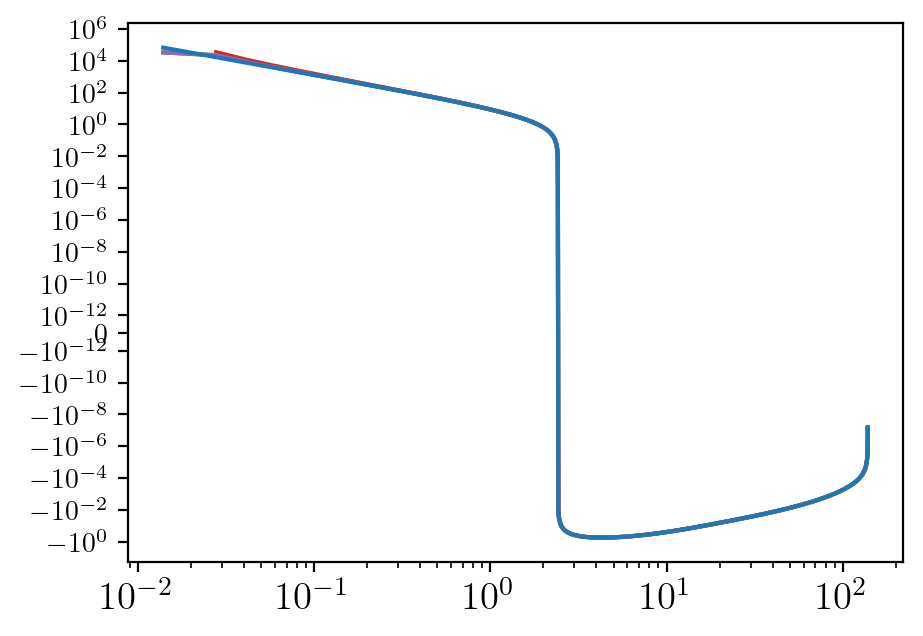

In [18]:
from scipy.interpolate import interp1d
ρ = npa.ρi - npa.ne
ρ = interp1d(npa.grid.xs, ρ, bounds_error=False, fill_value='extrapolate')(npa.iet.r_array*npa.rs)# ρ = -np.exp(-npa.grid.xs**2/(2*1**2))*npa.grid.xs**5
ρ *= -13/np.sum(4*π*npa.iet.r_array**2*rs**3*ρ*npa.iet.del_r)

Q = np.array([np.sum((4*π*npa.iet.r_array**2*rs**3*ρ*npa.iet.del_r)[:i]) for i in range(len(npa.iet.r_array))])
E_from_Q = (Z + Q)/npa.iet.r_array**2/rs**2

fig,ax = plt.subplots()
ax.plot(npa.iet.r_array*rs, E_from_Q, zorder=10)
φe = npa.iet.FT_k_2_r((npa.iet.FT_r_2_k(ρ)*4*π/(npa.iet.k_array/npa.rs)**2))
φi = Z/npa.iet.r_array/rs 
φ = φe + φi
ax.plot(npa.iet.r_array[1:]*rs, -(φ[1:]-φ[:-1])/npa.iet.del_r/rs )
ax.plot(npa.iet.r_array*rs, -np.gradient(φ, npa.iet.r_array*rs) )

ax.plot(npa.iet.r_array[1:]*rs, -(φ[1:]-φ[:-1])/npa.iet.del_r/rs )
ax.plot(npa.iet.r_array*rs, -np.gradient(φ, npa.iet.r_array*rs) )

ax.set_yscale('symlog', linthresh=1e-12)
ax.set_xscale('log')
# ax.set_xlim(1,2)

In [5]:
np.mean((φe_iet/φe_tri)[:-1]), np.std((φe_iet/φe_tri)[:-1]), 1/4/np.pi

NameError: name 'φe_iet' is not defined

Q_err:  2.220446049250313e-16
-23.563884645929424
-6.406401660738162


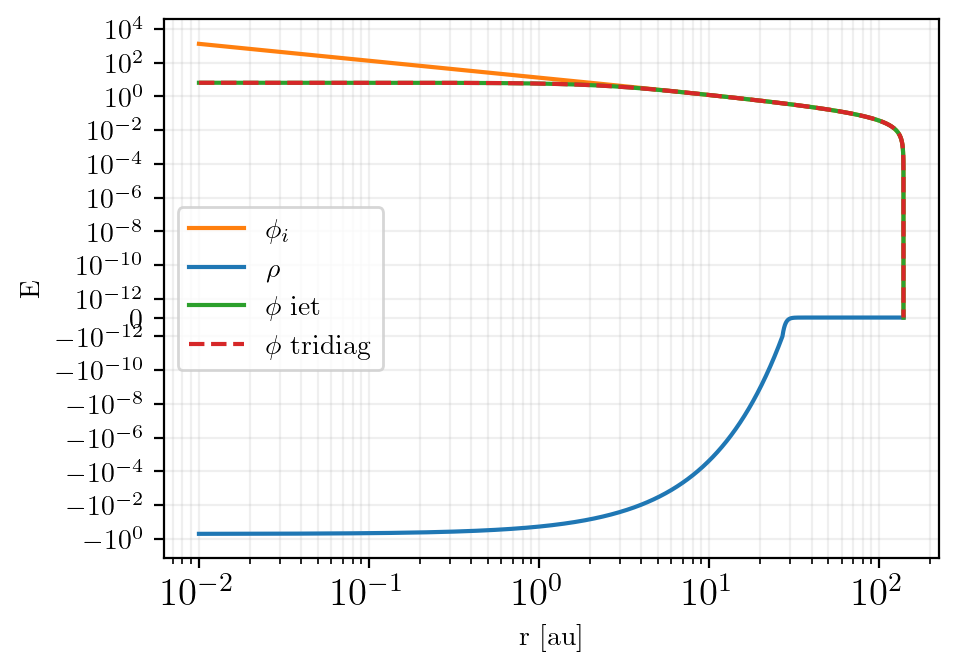

In [20]:
from scipy.interpolate import interp1d
# ρ = npa.ρi - npa.ne
# ρ = interp1d(npa.grid.xs, ρ, bounds_error=False, fill_value='extrapolate')(npa.iet.r_array*npa.rs)# ρ = -np.exp(-npa.grid.xs**2/(2*1**2))*npa.grid.xs**5
ρ = -np.exp(-npa.grid.xs/1)
ρ *= np.abs(Z/npa.grid.integrate_f(ρ))
# ρ = npa.ρ0_r_iet

print("Q_err: ", -Z/npa.grid.integrate_f(ρ)-1)

print(np.min(npa.φe))
npa.φe = npa.get_φe_iet(ρ)[0].copy()
# npa.φe = npa.get_φe_screened(npa.ρi - npa.ne)[0].copy()
print(np.min(npa.φe))
φe_iet = npa.get_φe_iet(ρ)[0].copy()
φe_iet = φe_iet - φe_iet[-1]
φe_tri = npa.get_φe(ρ)[0].copy()
φe_tri = φe_tri - φe_tri[-1]


fig, ax = plt.subplots()


# ax.plot(npa.grid.xs, ρ)
# ax.plot(npa.grid.xs, npa.ρ0_r_iet/npa.grid.xs)
# ax.plot(npa.iet.r_array*rs, npa.iet.ρ_r - npa.iet.ρ0_r)
E_from_Q = (npa.get_Q_profile(ρ) + Z)/npa.grid.xs**2
# ax.plot(npa.grid.xs, E_from_Q, '-',color=color_cycle[0], label=r'$Q/r^2$' ,zorder=10)
# ax.plot(npa.grid.xs, npa.grid.integrate_f(E_from_Q) - npa.get_Q_profile(E_from_Q), '-',color=color_cycle[0], label=r'$Q/r^2$' ,zorder=1)
# ax.plot(npa.grid.xs, -npa.grid.dfdx(npa.φe0_iet + npa.φion), '--',color=color_cycle[3], label=r'$\vec{E_0}_{tri}$',zorder=2)
# ax.plot(npa.grid.xs, -npa.grid.dfdx(φe_iet-npa.φe0_iet), ':',color=color_cycle[3], label=r'$\delta\vec{E}_{iet}$',zorder=2)
# ax.plot(npa.grid.xs, -npa.grid.dfdx(φe_iet + npa.φion), '-',color=color_cycle[3], label=r'$\vec{E}_{iet}$',zorder=2)
# ax.plot(npa.grid.xs, -npa.grid.dfdx(φe_tri + npa.φion), '-',color=color_cycle[2], label=r'$\vec{E}_{tri}$',zorder=1)

# ax.plot(npa.grid.xs, -φe_iet,'-', color=color_cycle[5] ,label=r'$\phi$ iet')
# ax.plot(npa.grid.xs, npa.φion,':', color=color_cycle[6] ,label=r'$\phi$ iet')

# ax.plot(npa.grid.xs, -npa.grid.dfdx(-φe_iet),'--', color=color_cycle[4] ,label=r'$E_e$ iet')
# ax.plot(npa.grid.xs, -npa.grid.dfdx(-φe_tri),'--', color=color_cycle[5] ,label=r'$E_e$ tri')
# ax.plot(npa.grid.xs, -npa.grid.dfdx(npa.φion),':', color=color_cycle[6] ,label=r'$E_i$')

ax.plot(npa.grid.xs, npa.φion,'-', color=color_cycle[1] ,label=r'$\phi_i$')
ax.plot(npa.grid.xs, ρ,'-', color=color_cycle[0] ,label=r'$\rho$')
ax.plot(npa.grid.xs, -φe_iet + 0*npa.φion,'-', color=color_cycle[2] ,label=r'$\phi$ iet')
# ax.plot(npa.grid.xs, npa.φe0_iet-npa.φe0_iet[-1] + npa.φion,':', color=color_cycle[2] ,label=r'$\phi_0$ iet')
# ax.plot(npa.iet.r_array*rs, npa.iet.δφe_r,'--', color=color_cycle[2] ,label=r'$\delta \phi$ iet')
ax.plot(npa.grid.xs, -φe_tri + 0*npa.φion,'--', color=color_cycle[3], label=r'$\phi$ tridiag')
# ax.plot(npa.grid.xs, φe_tri - φe_iet,':', color='k', label=r'$\phi Error$ ')


ax.set_ylabel('E')
ax.set_xlabel('r [au]')
ax.set_yscale('symlog', linthresh=1e-12)
ax.set_xscale('log')
# ax.set_xlim(0.07,0.12)
ax.legend()
ax.grid(which='both', alpha=0.2)
# ax.set_ylim(-1, None)

In [ ]:
stop

In [ ]:
%%time
npa.solve_TF(verbose=True, picard_alpha=0.01, tol=1e-12, nmax = 1000, n_wait_update_Zstar= 200)
npa.set_uii_eff()

In [ ]:
limiting_μ = npa.get_μ_infinite()
neutral_μ = npa.get_μ_neutral()
print(f"Neutral μ = {neutral_μ:0.9e}, vs. r->infinity μ={limiting_μ:0.9e}, {neutral_μ/limiting_μ - 1:0.9e}")
# Final μ = 5.66492e-01, vs. expected r->infinity μ=5.66507e-01, Err=-2.664e-05

In [ ]:
# %%time
from scipy.interpolate import interp1d
aa.solve_TF(verbose=True, picard_alpha=0.2, tol=1e-12)
aa.set_uii_eff()
aa.iet.HNC_solve(iters_to_wait=1e5, alpha_Picard=1e-2, tol=1e-12, verbose=False, num_iterations=1e5)
aa.gii = interp1d(aa.iet.r_array*aa.rs, aa.iet.h_r_matrix[0,0]+1, bounds_error=False, fill_value='extrapolate')(aa.grid.xs)
# npa_2.gii = interp1d(npa.iet.r_array*npa.rs, aa.iet.h_r_matrix[0,0]+1, bounds_error=False, fill_value='extrapolate')(npa.grid.xs)
aa.make_ρi()

In [ ]:
# fig, axs  = plt.subplots(1,2,figsize=(10,4))

# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# short_distance_weight = np.exp(-(0.08*npa.kTF*npa.grid.xs)**4)
# for ax in axs:
#     # ax.plot(npa.iet.r_array*rs, npa.iet.h_r_matrix[0,0], color=colors[0], label=r"NPA: $u_Y$")
#     ax.plot(npa.grid.xs, npa.gii-1, color=colors[0], label=r"NPA: $u_Y$")
#     # ax.plot(npa_2.grid.xs, npa_2.gii-1,'--', color=colors[0], label=r"NPA: $u_{AA}$",zorder=10)
#     ax.plot(aa.iet.r_array*rs, aa.iet.h_r_matrix[0,0],color=colors[1],  label=r"$u_{AA}$")
#     # ax.plot(npa.grid.xs, short_distance_weight*(npa.gii-1),'--',color=colors[3],  label=r"$u_Y$ damped")
    			

#     # ax.plot(aa.grid.xs, aa.gii-1,'--',color=colors[3],  label=r"$u_Y$")
#     ax.axvline(npa.iet.r_array[-1]*rs,color='k')
    
# ax = axs[0]
# ax.set_xlabel(r"$r/r_i$",fontsize=12)
# ax.set_ylabel("h(r)",fontsize=12)
# ax.set_xlim(0,3*rs)

# ax = axs[1]
# ax.set_xlabel(r"$r/r_i$",fontsize=12)
# ax.set_ylabel("h(r)",fontsize=12)
# ax.set_xscale('log')
# ax.set_xlim(0.5,None)
# ax.set_yscale('symlog', linthresh=1e-6)
# for ax in axs:
#     ax.legend(fontsize=12)
#     ax.tick_params(labelsize=12)


# plt.tight_layout()



In [ ]:
# ρ_iet = interp1d(npa.grid.xs, npa.ρi - npa.ne, bounds_error=False, fill_value=( (npa.ρi - npa.ne)[0],  (npa.ρi - npa.ne)[-1]))(npa.iet.r_array*rs)
# δφe_k = 4*π*npa.iet.FT_r_2_k(ρ_iet)/(npa.iet.k_array/rs)**2
# δφe_r = npa.iet.FT_k_2_r(δφe_k)
# φe = interp1d(npa.iet.r_array*rs, δφe_r, bounds_error=False, fill_value='extrapolate')(npa.grid.xs)
# ne_iet = npa.get_ne_TF(φe-φe[-1], npa.ne, npa.μ, npa.ne_bar)

In [ ]:
# fig, ax = plt.subplots(figsize=(5,3.5))

# # φ
# # ax.plot(npa.grid.xs, φe)
# # ax.plot(npa.grid.xs, npa.φe)

# # n
# ax.plot(npa.grid.xs, npa.ne)
# ax.plot(npa.grid.xs, ne_iet)


# ax.set_yscale('symlog', linthresh=1e-8)
# ax.set_xscale('log')

### Thomas Fermi (TF)

In [ ]:
# 2000: -5.419e-02, 4000: 1.592e-02

In [ ]:
# %%time
# npa_2.solve_TF(verbose=True, picard_alpha=0.2, num_10folds_per_rs=0.5, tol=1e-7, nmax = 1000, n_wait_update_Zstar= 200)
# npa_2.set_uii_eff()

### EOS

In [ ]:
def get_Eii(aa):
    βVeff = aa.get_βVeff(aa.φe, aa.ne, aa.ne_bar)
    η = aa.μ/aa.Te - βVeff
    βU = aa.grid.integrate_f(βVeff*aa.ne)
    I_onehalf = FermiDirac.Ionehalf(η)
    I_threehalf = FermiDirac.Ithreehalf(η)
    
    βK = (2*aa.Te)**1.5/π**2 * aa.grid.integrate_f( η*I_onehalf - 2/3 * I_threehalf   )
    return βU, βK, βU + βK

def get_ETF(aa):
    
def get_Exc(aa):
    aa.vxc

def get_E_Hartree(aa):
    
    
    

# get_E(aa_tfd), get_E(npa_tfd)

In [ ]:
def get_P(aa):
    aa_old_βu = aa.iet.βu_r_matrix.copy()
    # aa.iet.set_βu_matrix( np.array([[1/aa.Ti * aa.Zstar**2/(aa.iet.r_array*aa.rs) ]] ))
    P_id_hnc, P_ex_hnc, P_hnc = aa.iet.ideal_pressure(), aa.iet.excess_pressure(), aa.iet.total_pressure()
    P_id_AU, P_ex_AU, P_AU  = P_id_hnc/rs**3, P_ex_hnc/rs**3, P_hnc/rs**3
    aa.iet.set_βu_matrix(aa_old_βu)
    return P_id_AU, P_ex_AU, P_AU

aa_P_ions = get_P(aa_tfd)
aa_P_ions[1]/aa_P_ions[0]

## Comparison

In [ ]:
npa.make_plots()

In [ ]:
def plot_convergence(aa, axs=None):
    if axs is None:
        fig, axs = plt.subplots(ncols=3,figsize=(18,5),facecolor='w', dpi=200)
    
    # ELectric potential
    slice_by_num = 10
    ax = axs[0]
    colors = plt.cm.coolwarm(np.linspace(0, 1,len(aa.φe_list[::slice_by_num])))
    for i, (φe, ne, μ, ne_bar) in enumerate(zip(aa.φe_list[::slice_by_num], aa.ne_list[::slice_by_num], aa.μ_list[::slice_by_num],aa.ne_bar_list[::slice_by_num])):
        if i ==0 or i==len(aa.φe_list[::slice_by_num])-1:
            ax.plot(aa.grid.xs, (φe+aa.φion),linewidth=1,color=colors[i],alpha=1, label=r'$\phi_e$'.format(i))
            # ax.plot(aa.grid.xs, -aa.grid.dfdx(φe+aa.φion),linewidth=1,color=colors[i],alpha=1, label=r'$\vec E$'.format(i))
            # ax.plot(aa.grid.xs, aa.get_βVeff(φe, ne, ne_bar),linewidth=1,color=colors[i],alpha=1, label=r'$\beta V_{{\rm eff}}$'.format(i))
        else:
            ax.plot(aa.grid.xs, φe+aa.φion,linewidth=1,color=colors[i],alpha=1)
            # ax.plot(aa.grid.xs, -aa.grid.dfdx(φe+aa.φion),linewidth=1,color=colors[i],alpha=1)
            # ax.plot(aa.grid.xs, aa.get_βVeff(φe, ne, ne_bar),linewidth=1,color=colors[i],alpha=1)
    # ax.plot(aa.grid.xs, aa.get_φe( (aa.ρi - aa.ne) )[0] + aa.φion  ,'k:', label=r'$\phi$ check') 
    ax.set_yscale('symlog',linthresh=1e-10)
    ax.plot(aa.grid.xs, aa.φe_init + aa.φion, 'k:')

    # number density
    ax = axs[1]
    for i, (ne, ρi) in enumerate(zip(aa.ne_list[::slice_by_num], aa.ρi_list[::slice_by_num])):
        if i ==0 or i==len(aa.ne_list[::slice_by_num])-1:
            if i==0: 
                ne_bar_0 = ne[-1]
            ax.plot(aa.grid.xs, [aa.grid.integrate_f(-ne + ρi, end_index = index) + aa.Z for index in range(len(aa.grid.xs))],linewidth=1,color=colors[i],alpha=1, label=r'$Q(r)$'.format(i*slice_by_num))
            # ax.plot(aa.grid.xs, -ne + 0*ρi + ne[-1],linewidth=1,color=colors[i],alpha=1, label=r'$\rho$'.format(i))
            # ax.plot(aa.grid.xs, -ne + ρi,linewidth=1,color=colors[i],alpha=1, label=r'$\rho$'.format(i))
            # ax.plot(aa.grid.xs, -ne + ne_bar_0,linewidth=1,color=colors[i],alpha=1, label=r'$\rho$'.format(i))
            # ax.plot(aa.grid.xs, -ρi[-1] + ρi,linewidth=1,color=colors[i],alpha=1, label=r'$\rho$'.format(i))
            # pass
        else:
            ax.plot(aa.grid.xs, [aa.grid.integrate_f(-ne + ρi, end_index = index) + aa.Z for index in range(len(aa.grid.xs))],linewidth=1,color=colors[i],alpha=1)
            # print(ne[-1]-ne_bar_0)
            # ax.plot(aa.grid.xs, -ne + ρi ,linewidth=1,linestyle='-',color=colors[i],alpha=0.5)
            # ax.plot(aa.grid.xs, -ne + ne_bar_0 ,linewidth=1,linestyle='-',color=colors[i],alpha=0.5)
            # ax.plot(aa.grid.xs, -ρi[-1]+ ρi ,linewidth=1,linestyle='-',color=colors[i],alpha=0.5)
            pass
    # for i in range(int(aa.R/aa.rs)):
    #     ax.axvline(aa.rs*i, color='k', linestyle='--', alpha=0.2)
    # ax.set_xscale('log')
    # ax.plot(aa.grid.xs, (aa.gii)-1, 'k:')
    ax.set_yscale('symlog',linthresh=1e-4)

            
    # number density
    ax = axs[2]
    for i, (φe, ne, μ, ne_bar) in enumerate(zip(aa.φe_list[::slice_by_num], aa.ne_list[::slice_by_num], aa.μ_list[::slice_by_num],aa.ne_bar_list[::slice_by_num])):
        ne_TF = aa.get_ne_TF(φe, ne, μ, ne_bar)
        if i ==0 or i==len(aa.ne_list[::slice_by_num])-1:
            # ax.plot(aa.grid.xs, ne - 0*ne_TF,linewidth=1,color=colors[i],alpha=1, label=r'$n_e/n_e^{{TF}}-1$, iter: {0}'.format(i))
            ax.plot(aa.grid.xs, ne_TF-ne_TF[-1],linewidth=1,color=colors[i],alpha=1, label=r'$n_e^{{TF}} - n_e^{{TF}}[-1]$, iter: {0}'.format(i*slice_by_num))
            # ax.plot(aa.grid.xs, ne-ne[-1],linewidth=1,color=colors[i],linestyle='--',alpha=1, label=r'$n_e - n_e[-1]$, iter: {0}'.format(i))
            # pass
        else:
            # ax.plot(aa.grid.xs, ne - 0*ne_TF, linewidth=1,linestyle='-',color=colors[i],alpha=0.5)
            ax.plot(aa.grid.xs, ne_TF-ne_TF[-1],linewidth=1,color=colors[i],alpha=1)
            # ax.plot(aa.grid.xs, ne-ne[-1], linewidth=1,linestyle='--',color=colors[i],alpha=0.5)
            

            # print(np.abs(ne/ne_TF-1))
            # print(np.where( np.abs(ne/ne_TF-1)>1e-6 ))
            # print(aa.grid.xs[np.where( np.abs(ne/ne_TF-1) > 1e-8)][0]/10, 1/(np.sum(aa.grid.xs*np.abs(ne/ne_TF-1))/np.sum(np.abs(ne/ne_TF-1))))
    # ax.set_ylim()
    # ax.plot(aa.grid.xs, npa.get_ne_TF(npa.φe, npa.ne, npa.μ, npa.ne_bar) - npa.get_ne_TF(npa.φe, npa.ne, npa.μ, npa.ne_bar)[-1] , 'k:')
    ax.plot(aa.grid.xs, aa.get_ne_TF(aa.φe, aa.ne_bar*np.ones_like(aa.ne), aa.μ, aa.ne_bar) - aa.get_ne_TF(aa.φe, aa.ne_bar*np.ones_like(aa.ne), aa.μ, aa.ne_bar)[-1] , 'k:')
    ax.set_yscale('symlog',linthresh=1e-10)
    # ax.set_xscale('log')
    for ax in axs:
        ax.legend(fontsize=14)
        ax.tick_params(labelsize=14)
        ax.plot(aa.grid.xs, np.zeros_like(aa.ne),'k', alpha=0.2)
    plt.tight_layout()
    
# plot_convergence(aa)
plot_convergence(npa)

In [ ]:

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

petrov = pd.read_csv("../data/GP_TFDW_Al_1eV_solid.dat",header=0, comment='#', delim_whitespace=True)

def compare_aa(aa_list, axs=None, name=''):
    eV = 0.0367512 # So 4 eV = 4 * 0.036.. in natural units
    if axs is None:
        fig, axs = plt.subplots(ncols=2,figsize=(20,8),facecolor='w')

    # Density * 4pi r^2 plot
    for ax in axs:
        for aa, color in zip( aa_list, colors):
            factor = 4*np.pi*aa.grid.xs**2
            ax.plot(np.array(petrov['r/R'])*rs, 4*π*(np.array(petrov['r/R'])*rs)**2*(petrov['ne']/m_to_AU**3), 'k--', label="Petrov AA")
            ax.plot(aa.grid.xs, aa.ne*factor ,'-',color=color, label=r'$n_e$: '+ name)
            ax.plot(aa.grid.xs, aa.n_b*factor,'--',color=color,  label=r'$n_b$: ' + name)
            ax.plot(aa.grid.xs, aa.n_f*factor,':',color=color,  label=r'$n_f$: ' + name)
            if aa.rs != aa.R:
                ax.plot(aa.grid.xs, aa.ρi*factor,'-',color='r',  label=r'$\rho_i$: ' + name)
                ax.plot(aa.grid.xs, (aa.ρi-aa.ne)*factor,'--',color='r',  label=r'$\rho_i+\rho_e$: ' + name)
        # axs[0].plot(aa.grid.xs, aa.δn_f*factor,'--',color='g',  label=r'$n_e^{sc}$: ' + name)


    axs[0].set_ylabel(r'$4 \pi r^2 n_e(r) $ [A.U.]',fontsize=20)
    axs[0].set_ylim(0, 1e3)
    axs[0].set_yscale('symlog',linthresh=1e-1)
    axs[0].set_xscale('log')
    axs[0].set_xlim(aa.grid.xs[0],aa.grid.xs[-1])

    axs[1].set_ylabel(r'$4 \pi r^2 n_e(r) $ [A.U.]',fontsize=20)
    axs[1].set_ylim(0, 13)
    axs[1].set_xlim(0, np.min([aa.R,1.3*aa.rs]))

        
    for ax in axs:
        ax.set_xlabel(r'$|r-R_1|$ [A.U.]',fontsize=20)
        ax.legend(loc="upper right",fontsize=20,labelspacing = 0.1)
        ax.tick_params(labelsize=20)
        ax.grid(which='both',alpha=0.4)

        # make textbox
        text = ("{0}\n".format(aa.name)+ 
            r"$r_s$ = " + "{0},    ".format(np.round(aa.rs,2)) +
            r"$R_{NPA}$ = " + "{0}\n".format(aa.R)  +
                r"$T_e$ = " + "{0} [A.U.] = {1} eV\n".format(np.round(aa.Te,2),np.round(aa.Te/eV,2)) + r"$\mu$ = " + "{0} [A.U.]\n".format(np.round(aa.μ,2)) +
                r"$Z^\ast = $" + "{0}".format(np.round(aa.Zstar,2))  )

        props = dict(boxstyle='round', facecolor='w')
        ax.text(0.25,0.95, text, fontsize=15, transform=ax.transAxes, verticalalignment='top', bbox=props)

    plt.tight_layout()
    name = "NPA_densities_{0}_rs{1}_{2}eV_R{3}.png".format(aa.name, np.round(aa.rs,2), np.round(aa.Te/eV,2) ,np.round(aa.R))
    plt.savefig("/home/zach/plasma/atomic_forces/average_atom/media/" + name, dpi=300, bbox_inches='tight',facecolor="w")
    
    
    return axs


axs = compare_aa([aa, npa])#, npa_2])
for ax in axs:
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), fontsize=16, loc='upper right')
# axs[1].set_ylim(1e-5,1e3)

## HNC and FT

In [ ]:
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['font.size'] =  16
plt.rcParams['legend.fontsize'] = 12
# Plot and Compare
fig, axs = plt.subplots(1,2, figsize=(10,4))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

axs[0].plot(aa.iet.k_array/rs, aa.Uei_iet_k*(aa.iet.k_array/rs)**2/(4*π) ,'--.',color=colors[0], label="AA" ) # Need to muultiply by some rs power???
axs[0].plot(npa.iet.k_array/rs, npa.Uei_iet_k*(npa.iet.k_array/rs)**2/(4*π) ,'--.',color=colors[1], label="NPA") # Need to muultiply by some rs power???
axs[0].plot(aa.iet.k_array/rs, aa.Zstar*np.ones_like(aa.iet.k_array),':', color=colors[0], label=f"Coulomb, Z={aa.Zstar:0.3f}")
axs[0].plot(npa.iet.k_array/rs, npa.Zstar*np.ones_like(npa.iet.k_array),':',color=colors[1], label=f"Coulomb, Z={npa.Zstar:0.3f}")

# axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_xlabel(r"$k$ [au]")
axs[0].set_ylabel(r"$U_{ei}$ [au]")

axs[1].plot(aa.iet.k_array/rs, aa.uii_k_eff_iet,'-', color=colors[0], label="AA")
axs[1].plot(aa.iet.k_array/rs, 4*π*aa.Zstar**2/(aa.iet.k_array/rs)**2,'--', color=colors[0], label=r"AA: $u_{{ii}}^0$, Z={0:0.3f}".format(aa.Zstar))
axs[1].plot(aa.iet.k_array/rs, 1/(aa.iet.k_array**2/rs**2/(4*π*aa.Zstar**2) + 1/aa.uii_k_eff_iet[0] ),'--', color=colors[0], label=r"AA: $u_{{ii}}^0$, Z={0:0.3f}".format(aa.Zstar))
# axs[1].plot(aa.iet.k_array/rs, uii_test,'--', color=colors[0], label=r"AA: $u_{{ii}}^0$, Z={0:0.3f}".format(aa.Zstar))


# axs[1].plot(npa.iet.k_array/rs, npa.uii_k_eff_iet,color=colors[1], label="NPA")
axs[1].plot(npa.iet.k_array/rs, 4*π*npa.Zstar**2/(npa.iet.k_array/rs)**2,'--', color=colors[1], label=r"NPA: $u_{{ii}}^0$, Z={0:0.3f}".format(npa.Zstar))



axs[1].set_yscale('symlog',linthresh=1e-4)
axs[1].set_ylim(0,1e5)
axs[1].set_xscale('log')
axs[1].set_xlabel(r"$k$ [au]")
axs[1].set_ylabel(r"$u^{\rm eff}_{ii}$ [au]")


for ax in axs:
    ax.legend(fontsize=12)
plt.tight_layout()

In [ ]:
uii_test = aa.iet.FT_k_2_r(aa.uii_k_eff_iet)/rs**3

In [ ]:
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['font.size'] =  16
plt.rcParams['legend.fontsize'] = 12
# Plot and Compare
fig, axs = plt.subplots(1,2, figsize=(10,4))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

axs[0].plot(aa.iet.r_array*rs, -aa.Zstar/(aa.iet.r_array*rs), color=colors[0], label=f"Coulomb, Z={aa.Zstar:0.3f}")
axs[0].plot(aa.iet.r_array*rs, -aa.Uei_iet ,':',color=colors[0], label="AA" ) # Need to muultiply by some rs power???
axs[0].plot(npa.iet.r_array*rs, -npa.Zstar/(npa.iet.r_array*rs),color=colors[1], label=f"Coulomb, Z={npa.Zstar:0.3f}")
axs[0].plot(npa.iet.r_array*rs, -npa.Uei_iet ,':',color=colors[1], label="NPA") # Need to muultiply by some rs power???
# axs[0].plot(npa_2.iet.r_array*rs, -npa_2.Zstar/(npa.iet.r_array*rs),color=colors[2], label=f"Coulomb, Z={npa.Zstar:0.3f}")
# axs[0].plot(npa_2.iet.r_array*rs, -npa_2.Uei_iet ,':',color=colors[2], label=r"NPA: $g_{AA}$") # Need to muultiply by some rs power???



axs[0].set_yscale('symlog',linthresh=1e-1)
axs[0].set_xscale('log')
axs[0].set_xlabel(r"$r$ [au]")
axs[0].set_ylabel(r"$U_{ei}$ [au]")

axs[1].plot(aa.iet.r_array*rs, 1/aa.Te * aa.uii_r_eff_iet, color=colors[0],linestyle='-', label='AA')
axs[1].plot(aa.iet.r_array*rs, 1/aa.Te *aa.Zstar**2/(aa.iet.r_array*rs ), color=colors[0] ,linestyle='--', label=f'Coulomb Z={aa.Zstar:0.3f}')
axs[1].plot(npa.iet.r_array*rs, 1/npa.Te *npa.uii_r_eff_iet, color=colors[1],linestyle='-', label='NPA')
axs[1].plot(npa.iet.r_array*rs, 1/npa.Te *npa.Zstar**2/(npa.iet.r_array*rs ), color=colors[1],linestyle='--', label=f'Coulomb Z={npa.Zstar:0.3f}' )
# axs[1].plot(npa_2.iet.r_array*rs, npa_2.uii_r_eff_iet, color=colors[2],linestyle='-', label=r"NPA: $g_{AA}$")
# axs[1].plot(npa_2.iet.r_array*rs, npa_2.Zstar**2/(npa_2.iet.r_array*rs ), color=colors[2],linestyle='--', label=f'Coulomb Z={npa.Zstar:0.3f}' )

axs[1].set_yscale('symlog',linthresh=1e-4)
axs[1].set_xscale('log')
axs[1].set_ylabel(r"$\beta U_{ii}$ [au]")
axs[1].set_xlabel(r"$r$ [au]")
axs[1].set_xlim(1,None)


for ax in axs:
    ax.legend(fontsize=10)
plt.tight_layout()

In [ ]:
npa.make_gii()
npa.make_ρi()
# npa_2.make_gii()
# npa_2.make_ρi()

In [ ]:
from scipy.interpolate import PchipInterpolator
from pandas import read_csv

fig, axs  = plt.subplots(1,2, figsize=(8,4))

# Data from community TCCW
upper_data = read_csv("/home/zach/plasma/hnc/TCCW/Final_TCCW/Fig5c_Upper.txt", delim_whitespace=True, header=1)
lower_data = read_csv("/home/zach/plasma/hnc/TCCW/Final_TCCW/Fig5c_Lower.txt", delim_whitespace=True, header=1)

ax = axs[0]
ax.fill_between(lower_data['r/ri'],lower_data['gii'], PchipInterpolator(upper_data['r/ri'], upper_data['gii'])(lower_data['r/ri']), alpha=0.5, color='k', label='Workshop DFT Spread')

# Average atom effective potential to gii
ax.plot(npa.grid.xs/rs, npa.gii, label=r"NPA: $u_{ii}^{\rm Y initial}$",linewidth=1, zorder=2)
# ax.plot(npa_2.grid.xs/rs, npa_2.gii, label=r"NPA: $u_{ii}^{\rm AA initial}$",linewidth=1, zorder=2)
ax.plot(aa.iet.r_array, aa.iet.h_r_matrix[0,0] + 1, label=r"AA: $u_{ii}^{\rm eff}$",linewidth=1, zorder=5)

ax.set_xlabel(r"$r/r_i$")
ax.set_ylabel("g(r)")
ax.set_xlim(0.7,3)
# ax.set_ylim(0,2)
ax.legend(fontsize=10)

ax = axs[1]
ax.fill_between(lower_data['r/ri'],lower_data['gii']-1, PchipInterpolator(upper_data['r/ri'], upper_data['gii'])(lower_data['r/ri']), alpha=0.5, color='k', label='Workshop DFT Spread')
# Average atom effective potential to gii
ax.plot(npa.grid.xs/rs, npa.gii-1, label=r"NPA: $u_{ii}^{\rm Y initial}$",linewidth=1, zorder=2)
# ax.plot(npa_2.grid.xs/rs, npa_2.gii-1, label=r"NPA: $u_{ii}^{\rm AA initial}$",linewidth=1, zorder=2)
ax.plot(aa.iet.r_array, aa.iet.h_r_matrix[0,0], label=r"AA: $u_{ii}^{\rm eff}$",linewidth=1, zorder=5)

ax.set_xlabel(r"$r/r_i$")
ax.set_ylabel("h(r)")
ax.set_xlim(0.7,10)
ax.set_ylim(0,2.5)
ax.set_yscale('symlog', linthresh=1e-4)

ax.legend(fontsize=8, loc='upper right')
plt.tight_layout()
